Question 1 

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

Taken label using 

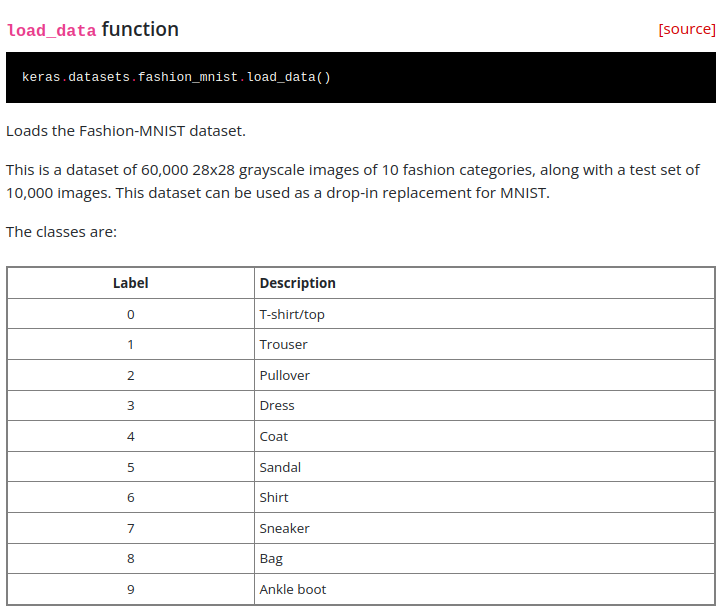


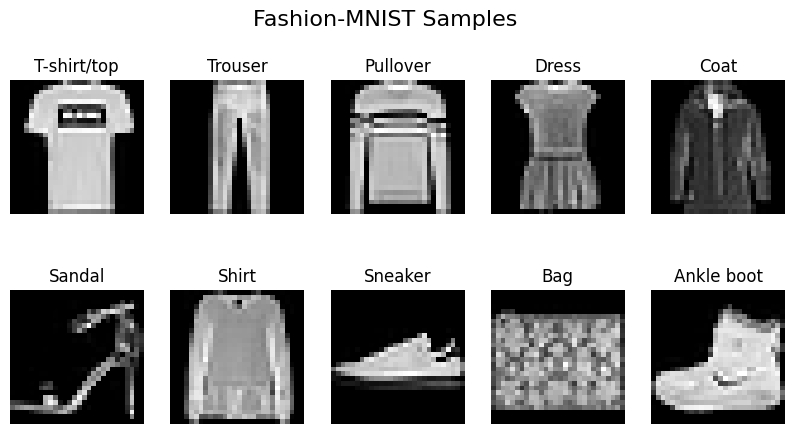

In [15]:

import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.datasets import fashion_mnist


(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


# identified classnames in keras website 

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


sample_images = []

for i in range(10):  # 10 classes in Fashion MNIST
    index = np.where(train_labels == i)[0][0]  # Find the first occurrence of each class
    sample_images.append(train_images[index])
    # sample_labels.append(class_names[i])
    
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Samples", fontsize=16)

for ax, img, label in zip(axes.flat, sample_images, class_names):
    ax.imshow(img, cmap='gray')  # Display grayscale image
    ax.set_title(label)  # Set class name as title
    ax.axis("off")  # Hide axes


Question 2 

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

In [16]:
# DATA PREPROCESSING

# Load Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(train_images.shape)
print(test_images.shape)

# Normalize pixel values (0-255) -> (0-1)

train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0



train_images = train_images[:25000]
test_images = test_images[:5000]

# One-hot encode labels
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels = one_hot_encode(train_labels[:25000])
test_labels = one_hot_encode(test_labels[:5000])


# train_images.shape
test_labels.shape

(60000, 28, 28)
(10000, 28, 28)


(5000, 10)

In [17]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_neurons, hidden_layers, output_neurons):
        
        self.layers = [input_neurons] + hidden_layers + [output_neurons]
        self.weights = {}
        self.biases = {}

        # Initialize weights and biases
        for i in range(len(self.layers) - 1):
            self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            self.biases[i] = np.zeros((1, self.layers[i+1]))


    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Avoid overflow
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        self.activations = {}
        self.z_values = {}

        # Input Layer
        self.activations[0] = X

        # Hidden Layers
        for i in range(len(self.layers) - 2):
            self.z_values[i] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            self.activations[i+1] = self.relu(self.z_values[i])

        # Output Layer (Softmax)
        last_layer = len(self.layers) - 2
        self.z_values[last_layer] = np.dot(self.activations[last_layer], self.weights[last_layer]) + self.biases[last_layer]
        self.activations[last_layer+1] = self.softmax(self.z_values[last_layer])

        return self.activations[last_layer+1]

    def train(self, X):
        activations = self.forward(X)
        print(activations)

# Example Usage:

hidden_layers = [128, 64]

# Initialize model
model = NeuralNetwork(input_neurons=784, hidden_layers=hidden_layers, output_neurons=10)

print(train_images.shape)

# Train (Assume train_images is your training data and train_labels is one-hot encoded labels)
model.train(train_images)


(25000, 784)


[[0.09993277 0.1000353  0.10003567 ... 0.09995704 0.09998122 0.09998062]
 [0.09991967 0.10009636 0.09998513 ... 0.09992911 0.09992141 0.09997475]
 [0.09995357 0.10003911 0.10001872 ... 0.09996295 0.09997056 0.0999948 ]
 ...
 [0.09995741 0.10002595 0.09999699 ... 0.09997681 0.09992209 0.10005136]
 [0.09995399 0.10002657 0.10002515 ... 0.09997282 0.0999682  0.09999338]
 [0.09993817 0.10005798 0.10003859 ... 0.09995177 0.09992372 0.10000457]]
